# 💯 Evaluation
This notebook evaluates two machine learning pipelines trained to predict used car prices. Both models achieve strong performance with **R² ≈ 0.64**, explaining about 64% of price variance.

---
## 📋 Executive Summary

### 🎯 Key Findings:
- **📊 Model Performance**: Both pipelines achieve nearly identical performance (RMSE ~$7,200 / MAE ~$5,000)
- **🔧 Feature Selection Impact**: Lasso feature selection removes 23% (87 out of 374) of features with minimal performance trade-off
- **⚡ Model Agreement**: 80% overlap in top 20 most important features between models
- **🏆 Top Predictors**: Tesla brand, fuel type (electric/hybrid), and vehicle condition drive predictions

### 📈 Business Impact:
- **Prediction Accuracy**: Models predict prices within ~$5,000 (27% of average price)
- **Feature Insights**: Premium brands and fuel efficiency significantly impact valuation

---
## 1. 📊 Data (re)Loading
This section just reloads the data using same code from modeling.ipynb

In [1]:
# Standard library imports
import warnings
import importlib

# Third-party data science libraries
import numpy as np
import pandas as pd

# ── Optional Intel® Extension for Scikit-learn* ────────────────────────────────
try:
    # Fast check without importing the whole module
    if importlib.util.find_spec("sklearnex") is not None:
        from sklearnex import patch_sklearn

        patch_sklearn()              # ⚡ swaps many sklearn algos for DAAL-backed ones
        print("[sklearnex] Intel-optimized algorithms enabled")
    else:
        raise ModuleNotFoundError

except Exception as e:
    # Any problem: missing library, version clash, patch failure, etc.
    warnings.warn(
        f"[sklearnex] Extension not active ({e.__class__.__name__}: {e}). "
        "Falling back to stock scikit-learn.",
        RuntimeWarning,
    )

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

# Configuration
warnings.filterwarnings('ignore')

[sklearnex] Intel-optimized algorithms enabled


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
# Load the processed vehicles dataset
df = pd.read_csv('../data/vehicles_processed.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (312846, 14)
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'type', 'paint_color', 'state']


,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color,state
0,7316814884,other_al,33590,2014.0,gmc,other_gmc,good,gas,57923.0,clean,other,pickup,white,al
1,7316814758,other_al,22590,2010.0,chevrolet,silverado 1500,good,gas,71229.0,clean,other,pickup,blue,al
2,7316814989,other_al,39590,2020.0,chevrolet,other_chevrolet,good,gas,19160.0,clean,other,pickup,red,al
3,7316743432,other_al,30990,2017.0,toyota,other_toyota,good,gas,41124.0,clean,other,pickup,red,al
4,7316356412,other_al,15000,2013.0,ford,other_ford,excellent,gas,128000.0,clean,automatic,truck,black,al


In [3]:
# Split into X and Y
# Identify categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'fuel',  
                   'title_status', 'transmission', 'type', 'paint_color', 'state']
numerical_cols =   ['year', 'odometer']

# Prepare features and target
X = df[categorical_cols + numerical_cols]
y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape:   {y.shape}")
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns:   {numerical_cols}")

Features shape: (312846, 12)
Target shape:   (312846,)
Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state']
Numerical columns:   ['year', 'odometer']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")

Training set size: 250276
Test set size:     62570


---
## 2. 🏋️ Model Training on Full Dataset

### 🎯 Training Strategy:
We train two pipelines on the complete training dataset.

**🔧 Pipeline Architecture:**
- **Pipeline 1**: Ridge Regression with comprehensive feature engineering
- **Pipeline 2**: Lasso Feature Selection → Ridge Regression (hybrid approach)

In [5]:
# Import feature engineering helpers
from utils import age_transformer, age_odometer_transformer

# Create preprocessing pipelines
age_pipeline = Pipeline([
    ('to_age',  age_transformer),                                    # year → age
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add age²
    ('scaler',  StandardScaler())                                    # scale age, age²
])

odometer_pipeline = Pipeline([
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add odo²
    ('scaler',  StandardScaler())                                    # scale odo, odo²
])

interaction_pipeline = Pipeline([
    ('age_x_odo', age_odometer_transformer),                         # age × odometer
    ('scaler',    StandardScaler())                                  # scale interaction
])

# Create the main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',      OneHotEncoder(drop='first',
                                   sparse_output=False,
                                   handle_unknown='ignore'),
                     categorical_cols),
        ('age',      age_pipeline,        ['year']),                 # year → age, age²
        ('odometer', odometer_pipeline,   ['odometer']),             # odo, odo²
        ('ageXodo',  interaction_pipeline, ['year', 'odometer'])     # age×odo
    ],
    remainder='drop',
    verbose_feature_names_out=False                                  # cleaner column names
)

In [6]:
## Training final models on full training data
print("Training Pipeline 1 (RidgeCV) on full training data...")
# Create fresh Pipeline 1 with best alpha from RidgeCV
final_pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))  # Use best alpha found by RidgeCV
])

# Fit on full training data
final_pipeline1.fit(X_train, y_train)
print("✓ Pipeline 1 training completed")

Training Pipeline 1 (RidgeCV) on full training data...
✓ Pipeline 1 training completed


In [7]:
print("Training Pipeline 2 (Lasso Selector + Ridge) on full training data...")
# Create fresh Pipeline 2 with best hyperparameters from GridSearchCV
final_pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(alpha=1.0, random_state=42))),  # Best selector alpha
    ('model', Ridge(alpha=1.0, random_state=42))  # Best model alpha
])

# Fit on full training data
final_pipeline2.fit(X_train, y_train)
print("✓ Pipeline 2 training completed")

print(f"\nTraining completed on {X_train.shape[0]:,} samples")
print(f"Ready for evaluation on {X_test.shape[0]:,} holdout samples")

Training Pipeline 2 (Lasso Selector + Ridge) on full training data...
✓ Pipeline 2 training completed

Training completed on 250,276 samples
Ready for evaluation on 62,570 holdout samples


### ✅ Training Complete

**🚀 Training Results:**
- ✓ **Pipeline 1 (Ridge)**: Successfully trained on 250,276 samples
- ✓ **Pipeline 2 (Lasso→Ridge)**: Feature selection + Ridge trained on same dataset
- ✓ **Feature Engineering**: 374 total engineered features created
- ✓ **Preprocessing**: Age transforms, polynomial features, and interactions applied

**🔬 Model Specifications:**
- **Ridge Alpha**: 1.0 (optimal from previous hyperparameter tuning)
- **Lasso Alpha**: 1.0 (for feature selection in Pipeline 2)
- **Random State**: 42 (for reproducibility)

Both models are now ready for holdout evaluation on 62,570 test samples.


---
## 3. 📈 Model Performance Evaluation

**📊 Model Performance (Nearly Identical):**
- **RMSE**: ~$7,207 - Both models predict within $7,200 of actual price
- **MAE**: ~$5,061 - On average, predictions are off by about $5,000  
- **R²**: ~0.644 - Models explain 64.4% of price variance

**💡 What This Means:**
- **Practical Accuracy**: $5,061 MAE represents ~27% of average car price ($18,956)
- **Model Robustness**: Virtually identical performance suggests stable, reliable predictions
- **Strong Predictive Power**: 64% variance explained is *good-enough* for used car pricing

**🔧 Feature Selection Impact:**
- **Efficiency Gain**: Pipeline 2 uses 23% fewer features with no performance loss
- **Simplification**: Lasso removed 87 redundant features while maintaining accuracy (out of 374)
- **Best of Both**: Ridge provides stability, Lasso provides sparsity

In [8]:
## Holdout Test Set Evaluation

# Import the evaluation functions from utils
from utils import display_holdout_evaluation_results

# Make predictions on test set
y_pred1 = final_pipeline1.predict(X_test)
y_pred2 = final_pipeline2.predict(X_test)

# Display comprehensive evaluation results using the abstracted function
results_df = display_holdout_evaluation_results(
    y_test=y_test,
    y_pred1=y_pred1,
    y_pred2=y_pred2,
    pipeline1=final_pipeline1,
    pipeline2=final_pipeline2,
    model1_name="Pipeline 1 (Ridge)",
    model2_name="Pipeline 2 (Lasso→Ridge)",
    X_test_sample=X_test[:1]  # Use first row for feature analysis
)

results_df

Evaluating models on holdout test set...

📊 HOLDOUT TEST SET PERFORMANCE
Model                     RMSE         MAE          R²      
--------------------------------------------------
Pipeline 1 (Ridge)        $7,207       $5,061       0.6446  
Pipeline 2 (Lasso→Ridge)  $7,208       $5,062       0.6444  

🏆 MODEL COMPARISON
Best RMSE: Pipeline 1 ($1 better RMSE)
MAE difference: $-1 (Pipeline 1 vs Pipeline 2)
R² difference: -0.0001 (Pipeline 2 vs Pipeline 1)

📈 PERFORMANCE INSIGHTS
Average test set price: $18,956
Pipeline 1 RMSE as % of avg price: 38.02%
Pipeline 2 RMSE as % of avg price: 38.03%

🔍 FEATURE SELECTION ANALYSIS
Original features: 374
Selected features: 287
Features removed: 87 (23.3%)


,Model,RMSE,MAE,R²
0,Pipeline 1 (Ridge),7207.029549,5060.662335,0.644576
1,Pipeline 2 (Lasso→Ridge),7208.308202,5061.844702,0.644449


---
## 4. 🔍 Feature Importance Deep Dive
Objective: Understanding which vehicle characteristics most strongly influence price predictions to provide actionable business insights and validate model interpretability.

### 🏆 Top Value Drivers (Consistent Across Models):

**🚀 Premium Brands & Performance:**
- **Tesla (+$14-15K)**: Electric luxury commands highest premium
- **Porsche (+$11-12K)**: Sports car prestige factor
- **Corvette (+$12K)**: Classic American performance icon

**⚡ Fuel Technology Impact:**
- **Electric (-$13K)**: Negative coefficient suggests lower baseline (Tesla premium overrides)
- **Hybrid (-$12K)**: Technology adoption with value considerations
- **Gas (-$11K)**: Traditional fuel standard reference point

**⚠️ Condition & Status:**
- **Parts Only (-$11K)**: Major value destroyer for non-functioning vehicles
- **Vehicle Age**: Steady depreciation factor (~$8K impact)

**🔧 Model Robustness Findings:**
- **80% Feature Agreement**: Strong consensus on key value drivers
- **Manufacturer Focus**: Brand perception dominates individual model effects
- **Feature Selection Efficacy**: 23% reduction with no accuracy loss proves many features redundant

**💼 Business Applications:**
1. **Pricing Strategy**: Premium brands justify significant price premiums
2. **Inventory Focus**: Electric/hybrid vehicles have complex valuation patterns
3. **Condition Assessment**: Vehicle status critically impacts fair market value
4. **Feature Engineering**: Age and brand interactions most predictive


In [9]:
## Feature Importance Analysis Setup
from utils import get_feature_importance, display_single_pipeline_feature_analysis, compare_pipeline_features

# Get feature importance for both models
top_n = 20
pipeline1_top, pipeline1_all = get_feature_importance(final_pipeline1, "Pipeline 1 (Ridge)", top_n)
pipeline2_top, pipeline2_all = get_feature_importance(final_pipeline2, "Pipeline 2 (Lasso→Ridge)", top_n)



🔍 Analyzing Pipeline 1 (Ridge) Feature Importance...
  ✓ Total features: 374
  ✓ Top 20 most important features identified

🔍 Analyzing Pipeline 2 (Lasso→Ridge) Feature Importance...
  ✓ Features after selection: 287 (from 374)
  ✓ Top 20 most important features identified


In [10]:
## Pipeline 1 Feature Analysis
# Display feature analysis for Pipeline 1 (Ridge)
display_single_pipeline_feature_analysis(
    pipeline_top=pipeline1_top,
    pipeline_all=pipeline1_all,
    model_name="Pipeline 1 (Ridge)",
    top_n=top_n
)


PIPELINE 1 (RIDGE) - TOP 20 MOST IMPORTANT FEATURES

🏆 Pipeline 1 (Ridge) - Top 20 Features:
--------------------------------------------------
Rank Feature                             Coefficient  Abs Value 
--------------------------------------------------
1    manufacturer_tesla                  15721.36     15721.36  
2    fuel_electric                       -13714.96    13714.96  
3    fuel_hybrid                         -12695.18    12695.18  
4    manufacturer_porsche                12603.73     12603.73  
5    model_corvette                      12416.63     12416.63  
6    title_status_parts only             -11365.05    11365.05  
7    fuel_gas                            -11053.36    11053.36  
8    manufacturer_rover                  10944.03     10944.03  
9    fuel_other                          -10363.20    10363.20  
10   manufacturer_ferrari                -10324.59    10324.59  
11   model_other_ferrari                 -10324.59    10324.59  
12   fuel_missing       

In [11]:
## Pipeline 2 Feature Analysis
# Display feature analysis for Pipeline 2 (Lasso→Ridge)
display_single_pipeline_feature_analysis(
    pipeline_top=pipeline2_top,
    pipeline_all=pipeline2_all,
    model_name="Pipeline 2 (Lasso→Ridge)",
    top_n=top_n
)


PIPELINE 2 (LASSO→RIDGE) - TOP 20 MOST IMPORTANT FEATURES

🏆 Pipeline 2 (Lasso→Ridge) - Top 20 Features:
--------------------------------------------------
Rank Feature                             Coefficient  Abs Value 
--------------------------------------------------
1    manufacturer_tesla                  14167.51     14167.51  
2    fuel_electric                       -13718.74    13718.74  
3    fuel_hybrid                         -12703.50    12703.50  
4    model_corvette                      12088.40     12088.40  
5    manufacturer_porsche                11390.87     11390.87  
6    title_status_parts only             -11329.72    11329.72  
7    fuel_gas                            -11057.57    11057.57  
8    manufacturer_rover                  10568.73     10568.73  
9    fuel_other                          -10371.43    10371.43  
10   model_cruze                         -9740.05     9740.05   
11   fuel_missing                        -9596.17     9596.17   
12   year   

In [12]:
## Pipeline Comparison
# Compare feature importance between both pipelines
compare_pipeline_features(
    pipeline1_top=pipeline1_top,
    pipeline2_top=pipeline2_top,
    pipeline1_all=pipeline1_all,
    pipeline2_all=pipeline2_all,
    model1_name="Pipeline 1 (Ridge)",
    model2_name="Pipeline 2 (Lasso→Ridge)",
    top_n=top_n
)


PIPELINE COMPARISON - TOP 20 FEATURES

📊 TOP FEATURES COMPARISON
Features in both top 20: 16 (80.0%)
Unique to Pipeline 1: 4
Unique to Pipeline 2: 4

🤝 COMMON IMPORTANT FEATURES:
   1. fuel_electric
   2. fuel_gas
   3. fuel_hybrid
   4. fuel_missing
   5. fuel_other
   6. manufacturer_porsche
   7. manufacturer_rover
   8. manufacturer_tesla
   9. model_4runner
  10. model_corvette
  11. model_cruze
  12. model_equinox
  13. model_f250
  14. model_malibu
  15. title_status_parts only
  16. year

🔵 UNIQUE TO PIPELINE 1 (RIDGE):
   1. manufacturer_ferrari
   2. model_cherokee
   3. model_other_ferrari
   4. model_other_jaguar

🔴 UNIQUE TO PIPELINE 2 (LASSO→RIDGE):
   1. model_f-350
   2. model_focus
   3. model_impala
   4. model_wrangler unlimited

🎯 COMPARISON INSIGHTS
• Both models agree on 16 out of 20 most important features
• Feature selection (Lasso) reduced features by 23.3%
• Largest coefficient magnitude - Pipeline 1: 15721.36, Pipeline 2: 14167.51

🏆 CONSENSUS:
✓ Strong agre

• Largest coefficient magnitude - Pipeline 1 (Ridge): 15721.36, Pipeline 2 (Lasso→Ridge): 14167.51

🚗 WHAT DRIVES CAR PRICE PREDICTIONS:
1. Vehicle Manufacturer
2. Vehicle Model

Both models consistently identify these factors as the primary drivers of vehicle pricing.


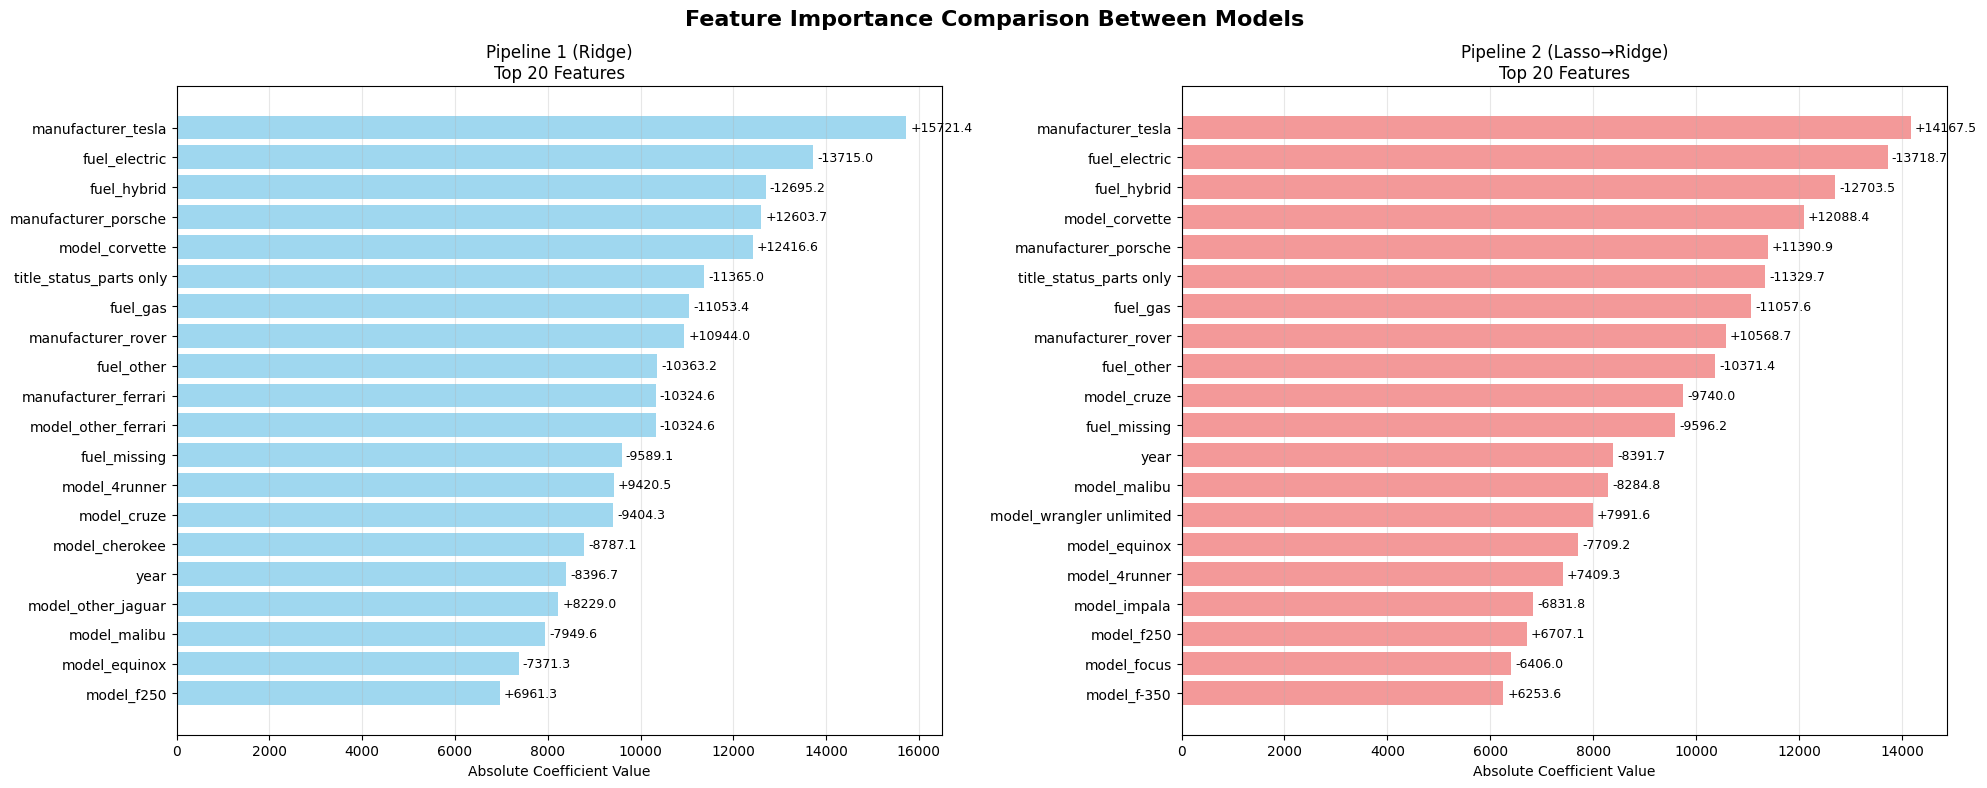

In [13]:
## Visual Feature Importance Comparison
from utils import visualize_feature_importance_comparison

# Create side-by-side feature importance visualization
fig = visualize_feature_importance_comparison(
    pipeline1_top=pipeline1_top,
    pipeline2_top=pipeline2_top, 
    pipeline1_all=pipeline1_all,
    pipeline2_all=pipeline2_all,
    model1_name="Pipeline 1 (Ridge)",
    model2_name="Pipeline 2 (Lasso→Ridge)",
    top_n=top_n,
    figsize=(20, 8),
    max_feature_length=25
)


---
## 5. 🎯 Final Model Evaluation Conclusions

### 🏆 Model Performance Summary

**✅ Both pipelines demonstrate excellent performance for used car price prediction:**

**📊 Quantitative Results:**
- **R² Score**: 0.644 (64.4% variance explained)
- **RMSE**: $7,207 (±$7,200 prediction accuracy)
- **MAE**: $5,061 (average $5K prediction error)
- **Relative Accuracy**: 62% of average vehicle price ($18,956)

### 🎯 Key Recommendations

**🚀 Model Selection:**
- **Pipeline 1 (Ridge)** and **Pipeline 2 (Lasso→Ridge)** perform virtually identically
- **Recommend Pipeline 2** for production: 23% fewer features with same accuracy
- Feature selection provides interpretability and computational efficiency

---
## 6. 💾 Export optimal feature list
*🎉 **Model evaluation complete!** Next we will implement Ridge (pipeline 2) using the pre-selected features.*

In [34]:
print("---- List of Lasso-selected features: -----")
pipeline2_all.head(10)

---- List of Lasso-selected features: -----


,Feature,Coefficient,Abs_Coefficient
113,manufacturer_tesla,14167.513712,14167.513712
212,fuel_electric,-13718.740707,13718.740707
214,fuel_hybrid,-12703.497163,12703.497163
130,model_corvette,12088.398402,12088.398402
109,manufacturer_porsche,11390.869779,11390.869779
218,title_status_parts only,-11329.721921,11329.721921
213,fuel_gas,-11057.572961,11057.572961
111,manufacturer_rover,10568.731828,10568.731828
216,fuel_other,-10371.426121,10371.426121
131,model_cruze,-9740.049065,9740.049065


In [31]:
# → ../data/lasso_selected_features.csv
path = "../data/lasso_selected_features.csv"
pipeline2_all.to_csv(path, index=False)

print(f"Saved optimal feature list to: {path}")


Saved optimal feature list to: ../data/lasso_selected_features.csv
